# Final Exam - Open

## FINM 37400 - 2025

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

Jose Luna 

Disclaimer: I used GitHub Copilot to improve and debug my functions.

***

# Instructions

## Please note the following:

Points
* You have `100` minutes to complete the exam.
* For every minute late you submit the exam, you will lose one point.

Rules
* The exam is open-material, closed-communication.
* You do not need to cite material from the course github repo - you are welcome to use the code posted there without citation.

Advice
* If you find any question to be unclear, state your interpretation and proceed. We will only answer questions of interpretation if there is a typo, error, etc.
* The exam will be graded for partial credit.

## Data

**All data files are found in the class github repo, in the `data` folder.**

- For Section 1:
    * No data file is needed.
- for Section 2:
    * `data/treasury_quotes_clean_2024-12-31.xlsx`, sheet `selected quotes`.

## Scoring

| Problem | Points |
|---------|--------|
| 1       | 70     |
| 2       | 30     |

***

## Submitting your Exam

Submission
* You will upload your solution to the `Exam - Open` assignment on Canvas. 
* Submit a compressed, "zipped", folder containing all code according to the file structure below.
* Name your submitted, zipped, folder `exam-open-LASTNAME-FIRSTNAME.zip`.
* Be sure to **submit** on Canvas, not just **save** on Canvas.

Your submission should **include all code and data used in your analysis** in the following folder structure.
* We strongly prefer all submissions are structred this way, and it will improve grading accuracy for partial credit. 
* Still, if you're struggling to get this working in time, no worries; just structure as comfortable and submit **everything used** for your submission.

__Exam Submission Structure:__

```plaintext
exam-open-LASTNAME-FIRSTNAME.zip/
│── exam-open.ipynb
│── data/
│   ├── example_data.csv
│── modules/
│   ├── my_functions.py

### Validating your folder structure

The next cell tests that you have this folder structure implemented.

In [23]:
from pathlib import Path
import sys
import pandas as pd

# Get the directory of the notebook (assumes Jupyter Notebook is always used)
BASE_DIR = Path().resolve()

# Define paths for data and modules
DATA_DIR = BASE_DIR / "data"
MODULES_DIR = BASE_DIR / "modules"

# Check if expected directories exist
if not DATA_DIR.exists():
    print(f"Warning: Data directory '{DATA_DIR}' not found. Check your file structure.")

if not MODULES_DIR.exists():
    print(f"Warning: Modules directory '{MODULES_DIR}' not found. Check your file structure.")

# Ensure Python can import from the modules directory
if str(MODULES_DIR) not in sys.path:
    sys.path.append(str(MODULES_DIR))

# Load exam data
EXAMPLE_DATA_PATH = DATA_DIR / "example_data.csv"

if EXAMPLE_DATA_PATH.exists():
    example_data = pd.read_csv(EXAMPLE_DATA_PATH)
else:
    print(f"Warning: '{EXAMPLE_DATA_PATH.name}' not found. Ensure it's in the correct directory.")


***

# 1. The "Steepener" Trade

A popular trade in 2024 was the 2s10s "steepener" trade, which was a trade designed to capture the changes in the slope of yield curve while being hedged to parallel shifts in it. In particular, the trade believes that the 2-year treasury yield is too high relative to the 10-year treasury yield. We will replicate this trade.

`Initial date:` July 1st, 2024 (corresponding to $t=0$)

__2-year Bond:__
- `Time To Maturity:` 2 years
- `Coupon Frequency:` semi-annual
- `Coupon Rate:` 4%
- `Annualized semi-annual YTM:` 4.74%

__10-year Bond:__
- `Time To Maturity:` 10 years
- `Coupon Frequency:` semi-annual
- `Coupon Rate:` 2%
- `Annualized semi-annual YTM:` 4.44%

__Note__: Assume that coupons are paid exactly at the $t=0.5, 1, 1.5, ...$ year marks. 

In [1]:
import pandas as pd
import numpy as np
import importlib

import modules.Help_Functions as hf
hf = importlib.reload(hf)

data = {
    "DATE0": ["2024-07-01", "2024-07-01"],
    "YTM": [0.0474, 0.0444],
    "CPNRATE": [0.04, 0.02],
    "MATURITY": [2, 10]
}
index = ["2y_bond", "10y_bond"]

summary = pd.DataFrame(data, index=index)
summary

,DATE0,YTM,CPNRATE,MATURITY
2y_bond,2024-07-01,0.0474,0.04,2
10y_bond,2024-07-01,0.0444,0.02,10


### 1.1. (5pts)
Based on the given information, report the dirty price of each bond as of $t=0$ assuming a face value of $100. Display your answer rounded to 4 decimal places.

In [2]:
summary.loc["2y_bond", "Price"] = hf.price_treasury_ytm(summary.loc["2y_bond", "MATURITY"],summary.loc["2y_bond", "YTM"], summary.loc["2y_bond", "CPNRATE"], freq=2)
summary.loc["10y_bond", "Price"] = hf.price_treasury_ytm(summary.loc["10y_bond", "MATURITY"],summary.loc["10y_bond", "YTM"], summary.loc["10y_bond", "CPNRATE"], freq=2)

summary[['Price']].style.format("{:.4f}")

,Price
2y_bond,98.6037
10y_bond,80.4684


### 1.2. (5pts)

Report the modified duration and modified-dollar-duration for each bond. Calculate these modified duration values with respect to changes in the quoted semi-annual YTM. Display your answer rounded to 4 decimal places.

In [3]:
summary.loc["2y_bond", "Duration"] = hf.duration_closed_formula(summary.loc["2y_bond", "MATURITY"],summary.loc["2y_bond", "YTM"], summary.loc["2y_bond", "CPNRATE"], freq=2)
summary.loc["10y_bond", "Duration"] = hf.duration_closed_formula(summary.loc["10y_bond", "MATURITY"],summary.loc["10y_bond", "YTM"], summary.loc["10y_bond", "CPNRATE"], freq=2)

summary.loc["2y_bond", "Mod_Duration"] = summary.loc["2y_bond", "Duration"] / (1 + summary.loc["2y_bond", "YTM"]/2)
summary.loc["10y_bond", "Mod_Duration"] = summary.loc["10y_bond", "Duration"] / (1 + summary.loc["10y_bond", "YTM"]/2)

summary.loc["2y_bond", "Mod_dollar_Duration"] = summary.loc["2y_bond", "Mod_Duration"] * summary.loc["2y_bond", "Price"]
summary.loc["10y_bond", "Mod_dollar_Duration"] = summary.loc["10y_bond", "Mod_Duration"] * summary.loc["10y_bond", "Price"]

summary[['Mod_Duration', 'Mod_dollar_Duration']].style.format("{:.4f}")

,Mod_Duration,Mod_dollar_Duration
2y_bond,1.8965,187.0042
10y_bond,8.7875,707.1151


### 1.3. (15pts)
We want to construct our portfolio in a modified-dollar-duration neutral fashion such that we are well hedged to parallel moves in the yield curve. 

Using the results from `1.2`, construct a portfolio aligned with the trade thesis that the YTM spread will converge, and go long one bond and short the other. 

Size the portfolio.
* Your position has a $1,000 (modified duration) exposure to a symmetric 1 basis-point convergence in the YTM spread.
* Assume the spread converges evenly, with 0.5bp convergence on each side.
* We assume no leverage is used. 

Report your position in each bond as:
* the notional amount.
* the market value.
* the number of bond contracts (assuming each contract has a face/par value of $100).

Display your answers rounded to the nearest integer.

In [91]:
long_key = "2y_bond"
short_key = "10y_bond"

Size = 1000/(0.01/100) # given 0.01% change in YTM spread, position with 1000 modified duration

summary.loc[long_key, "Contracts"] = Size / summary.loc[long_key, "Mod_dollar_Duration"]
summary.loc[short_key, "Contracts"] = -Size / summary.loc[short_key, "Mod_dollar_Duration"]
summary.loc[long_key, "Notional"] = summary.loc[long_key, "Contracts"] * 100
summary.loc[short_key, "Notional"] = summary.loc[short_key, "Contracts"] * 100
summary.loc[long_key, "Mkt_Value"] = summary.loc[long_key, "Contracts"] * summary.loc[long_key, "Price"]
summary.loc[short_key, "Mkt_Value"] = summary.loc[short_key, "Contracts"] * summary.loc[short_key, "Price"]

summary[['Contracts', 'Notional', 'Mkt_Value']].style.format("{:,.4f}")

,Contracts,Notional,Mkt_Value
2y_bond,"53,474.7222","5,347,472.2156","5,272,805.4382"
10y_bond,"-14,141.9688","-1,414,196.8800","-1,137,981.1787"


### 1.4. (10pts)

Assume we are now at $t=0.05$, and the bond yields have now moved.

__2-year Bond:__
- `Annualized semi-annual YTM:` 4.32%

__10-year Bond:__
- `Annualized semi-annual YTM:` 4.14%

For each bond, report the new dirty price and clean price. Display your answer rounded to 4 decimal places.

In [92]:
summary.loc["2y_bond", "New_YTM"] = 4.32/100
summary.loc["10y_bond", "New_YTM"] = 4.14/100

t = 0.05

summary.loc["2y_bond", "Clean_price"] = hf.price_treasury_ytm(summary.loc["2y_bond", "MATURITY"]-t,summary.loc["2y_bond", "New_YTM"], summary.loc["2y_bond", "CPNRATE"], freq=2)
summary.loc["10y_bond", "Clean_price"] = hf.price_treasury_ytm(summary.loc["10y_bond", "MATURITY"]-t,summary.loc["10y_bond", "New_YTM"], summary.loc["10y_bond", "CPNRATE"], freq=2)
summary.loc["2y_bond", "Acc_interest"] = (summary.loc["2y_bond", "CPNRATE"]*100/2)*(t/0.5)
summary.loc["10y_bond", "Acc_interest"] = (summary.loc["10y_bond", "CPNRATE"]*100/2)*(t/0.5)
summary.loc["2y_bond", "Dirty_price"] = summary.loc["2y_bond", "Clean_price"] + summary.loc["2y_bond", "Acc_interest"]
summary.loc["10y_bond", "Dirty_price"] = summary.loc["10y_bond", "Clean_price"] + summary.loc["10y_bond", "Acc_interest"]

summary[['Clean_price', 'Acc_interest', 'Dirty_price']].style.format("{:.4f}")

,Clean_price,Acc_interest,Dirty_price
2y_bond,99.6058,0.2000,99.8058
10y_bond,82.7910,0.1000,82.8910


### 1.5. (10pts)

Still at $t=0.05$, report the profit-and-loss **(PnL)** of each position, and also for the entire portfolio, using:
* Duration (first-order YTM changes).

Use the $t=0$ modified-dollar-duration values from part `1.2`. 

Display your answer rounded to 4 decimal places.

In [93]:
summary["Delta_YTM"] = summary["New_YTM"] - summary["YTM"]
summary["PnL"] = -summary["Mod_dollar_Duration"] * summary["Delta_YTM"] * summary["Contracts"]

summary[['Mod_dollar_Duration','Contracts','Delta_YTM', 'PnL']].style.format("{:,.4f}")

,Mod_dollar_Duration,Contracts,Delta_YTM,PnL
2y_bond,187.0042,"53,474.7222",-0.0042,"42,000.0000"
10y_bond,707.1151,"-14,141.9688",-0.0030,"-30,000.0000"


In [94]:
print(f"Total PnL: {summary['PnL'].sum():,.2f}")

Total PnL: 12,000.00


### 1.6 (10pts)

Repeat `1.5`, but this time uapproximating the PnL using
* Duration + convexity

In [95]:
summary.loc["2y_bond", "Convexity"] = hf.bond_convexity(summary.loc["2y_bond", "MATURITY"],summary.loc["2y_bond", "YTM"], summary.loc["2y_bond", "CPNRATE"], freq=2)
summary.loc["10y_bond", "Convexity"] = hf.bond_convexity(summary.loc["10y_bond", "MATURITY"],summary.loc["10y_bond", "YTM"], summary.loc["10y_bond", "CPNRATE"], freq=2)

summary["Dollar_Convexity"] = summary["Price"] * summary["Convexity"]


summary["PnL_2order"] = (
    - summary["Mod_dollar_Duration"] * summary["Delta_YTM"] * summary["Contracts"]
    + 0.5 * summary["Dollar_Convexity"] * (summary["Delta_YTM"] ** 2) * summary["Contracts"]
)

summary[['Mod_dollar_Duration', 'Dollar_Convexity','Contracts','Delta_YTM', 'PnL', 'PnL_2order']].style.format("{:,.4f}")

,Mod_dollar_Duration,Dollar_Convexity,Contracts,Delta_YTM,PnL,PnL_2order
2y_bond,187.0042,452.1336,"53,474.7222",-0.0042,"42,000.0000","42,213.2475"
10y_bond,707.1151,"7,006.7560","-14,141.9688",-0.0030,"-30,000.0000","-30,445.9020"


In [96]:
print(f"Total PnL with convexity: {summary['PnL_2order'].sum():,.2f}")

Total PnL with convexity: 11,767.35


### 1.7. (5pts)

Repeat `1.5`, but this time calculating the PnL via
* full repricing (using your pricing results from part `1.4`.)

Display the comparison of the PnL across the three methods of `1.5`, `1.6`, and `1.7`.

In [101]:
summary["PnL_Delta_Prices"] = (summary["Clean_price"] - summary["Price"])*summary["Contracts"]

summary[['Price', 'Clean_price', 'Contracts', 'PnL_Delta_Prices']].style.format("{:,.4f}")

,Price,Clean_price,Contracts,PnL_Delta_Prices
2y_bond,98.6037,99.6058,"53,474.7222","53,584.4765"
10y_bond,80.4684,82.7910,"-14,141.9688","-32,847.0707"


In [102]:
print(f"Total PnL with duration approx: {summary['PnL'].sum():,.2f}")
print(f"Total PnL with convexity: {summary['PnL_2order'].sum():,.2f}")
print(f"Total PnL with prices changes: {summary['PnL_Delta_Prices'].sum():,.2f}")

Total PnL with duration approx: 12,000.00
Total PnL with convexity: 11,767.35
Total PnL with prices changes: 20,737.41


### 1.8 (5 pts)

* What do the results from `1.6` capture that `1.5` does not, and why might this be important to consider?
* For any change in the YTM spread, do we expect the first order P/L estimate to always underestimate or overestimate the second order P/L estimate? Explain your reasoning.

*Answers :*

* In 1.6 we capture the second-order curvature  in the price-yield relationship, giving that duration (1.5) is only a linear approximation. If the YTM change is big, then the duration is not a good approximation, and additionally, 10y bond has a higher convexity than 2y, so it is more important take into account this second-order variation

* The first-order P/L always underestimate the second order PnL, given that is a straight line (linear relationship), and the real price in second order is a convex function, so the linear approximation is always bellow the second-order

### 1.9 (5pts)

Name two things the results from `1.7` capture that `1.6` does not.

(1) All the others higher order effects, giving that 1.6 is a taylor approximation of second order, ignoring the higher factors. 

(2) Also, we are using the duration of the first period, ignoring the change of 0.05 years, which change the duration and convexity a little. 

In this case, the “full repricing” is always the best method if you have the actual yield curve and the bond’s cash flows

***

# 2. Extracting Curves

Use the selected treasury quotes in the file, `treasury_quotes_clean_2024-12-31.xlsx`, using sheet `selected quotes`.

* Market quotes are provided for treasury securities expiring approximately every six months over the next `7` years.
* You are welcome to assume that they mature at exaclty six-year increments or to use the exact dates.
* Consider the `price` column to represent the dirty mid price.

In [2]:
import pandas as pd
import numpy as np
import modules.Help_Functions as hf

In [5]:
filepath = 'data/treasury_quotes_clean_2024-12-31.xlsx'
SHEET = 'selected quotes'
quotes = pd.read_excel(filepath,sheet_name=SHEET).set_index('KYTREASNO')
quotes

,type,quote date,issue date,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm
KYTREASNO,,,,,,,,,,,,,
208073,note,2024-12-31,2023-06-30,2025-06-30,0.495551,0,4.625,100.240638,100.250357,100.245498,0,100.245498,0.041613
208158,note,2024-12-31,2023-12-31,2025-12-31,0.999316,0,4.250,100.025370,100.044656,100.035013,0,100.035013,0.042172
208242,note,2024-12-31,2024-06-30,2026-06-30,1.494867,0,4.625,100.535515,100.566765,100.551140,0,100.551140,0.042566
208332,note,2024-12-31,2024-12-31,2026-12-31,1.998631,0,4.250,100.008215,100.016028,100.012122,0,100.012122,0.042469
207904,note,2024-12-31,2022-06-30,2027-06-30,2.494182,0,3.250,97.654701,97.685951,97.670326,0,97.670326,0.042520
207989,note,2024-12-31,2022-12-31,2027-12-31,2.997947,0,3.875,98.852192,98.887349,98.869770,0,98.869770,0.042838
208075,note,2024-12-31,2023-06-30,2028-06-30,3.496235,0,4.000,98.966035,99.009004,98.987520,0,98.987520,0.043197
208160,note,2024-12-31,2023-12-31,2028-12-31,4.000000,0,3.750,97.755138,97.802013,97.778576,0,97.778576,0.043617
208244,note,2024-12-31,2024-06-30,2029-06-30,4.495551,0,4.250,99.446447,99.493322,99.469884,0,99.469884,0.043856


### 2.1. (15pts)

Bootstrap the spot curve. 

For maturity `T=5`, report
* the discount factor
* the semiannually-compounded discount rate
* the continuously-compounded discount rate

Round your answers to four decimal places.

In [ ]:
RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_REDUNDANT = True

data = hf.filter_treasuries(quotes, filter_yld = RESTRICT_YLD, filter_tips = RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)


RESTRICT_DTS_MATURING = True

CF = hf.filter_treasury_cashflows(hf.calc_cashflows(data, adj_end_month = True), filter_maturity_dates=True)
# display(CF)

prices = quotes.loc[data.index, "dirty price"]

# Given that is a perfect squared matrix, we can use the inverse to solve the system of equations
discount_dataframe = pd.DataFrame( np.linalg.inv(CF) @ prices, index=quotes["ttm"].values, columns=["Discount_factor_spot"])
discount_dataframe["Spot_continuous_rate"] = -np.log(discount_dataframe["Discount_factor_spot"]) / discount_dataframe.index
discount_dataframe["Spot_semianual_rate"] =  hf.compound_rate(discount_dataframe["Spot_continuous_rate"],None,2)

print("Discount factors and spot rates for the 5y maturity:")
display(pd.DataFrame(discount_dataframe.iloc[5*2-1,:]).style.format("{:.4f}"))

Discount factors and spot rates for the 5y maturity:


,4.999316
Discount_factor_spot,0.8047
Spot_continuous_rate,0.0435
Spot_semianual_rate,0.0439


### 2.2. (10pts)

Use the bootstrapped spot curves to calculate the forward curves.

For maturity $T_1=5 \rightarrow T_2=5.5$, report
* the forward discount factor.
* the semiannually-compounded forward rate.
* the continuously-compounded forward rate.

Round your answers to four decimal places.

In [18]:
discount_dataframe["Fwd_discount_factor"] = discount_dataframe["Discount_factor_spot"]/discount_dataframe["Discount_factor_spot"].shift()
discount_dataframe["Fwd_discount_factor"].iloc[0] = discount_dataframe["Discount_factor_spot"].iloc[0]

discount_dataframe["Fwd_continuous_rate"] = -np.log(discount_dataframe["Fwd_discount_factor"]) / discount_dataframe.index.to_series().diff().mean()
discount_dataframe["Fwd_semianual_rate"] =  hf.compound_rate(discount_dataframe["Fwd_continuous_rate"],None,2)

print("Forward rates for the 5y maturity (from T1 = 5y to T2 = 5.5y):")
display(pd.DataFrame(discount_dataframe[["Fwd_discount_factor","Fwd_continuous_rate","Fwd_semianual_rate"]].iloc[5*2-1,:]).style.format("{:.4f}"))

Forward rates for the 5y maturity (from T1 = 5y to T2 = 5.5y):


C:\Users\josel\AppData\Local\Temp\ipykernel_20812\2236388237.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  discount_dataframe["Fwd_discount_factor"].iloc[0] = discount_dataframe["Discount_factor_spot"].iloc[0]


,4.999316
Fwd_discount_factor,0.9783
Fwd_continuous_rate,0.0438
Fwd_semianual_rate,0.0443


### 2.3. (5pts)

For which maturity ($T_1$ and $T_2$) is the forward rate highest?

<Axes: title={'center': 'Spot and forward rates'}, xlabel='Maturity (years)', ylabel='Rate (%)'>

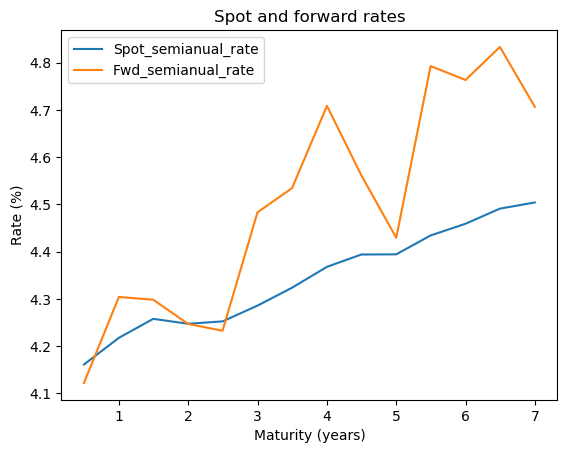

In [20]:
(discount_dataframe[["Spot_semianual_rate", "Fwd_semianual_rate"]]*100).plot(title="Spot and forward rates", ylabel="Rate (%)", xlabel="Maturity (years)")

*Answer :* We can see that in T2 = 5.5y the forward rate is higher than the fwd rate in T1 = 5y. This is because between T1 and T2 the spot rate increased, which means that the forward rate is higher than the spot rate and higher than the forward rate in T1.

***